# Домашнее задание к занятию «Задачи детекции и сегментации»

***Описание задания***:  
Необходимо по снимкам с камеры на рыболовецком судне классифицировать улов. Решение необходимо прислать в виде ссылки на ipython-ноутбук с указанием значения метрики на Leaderboard.

### Загрузка данных

In [1]:
import cv2
import os
import time
import json
import tempfile
import glob
from glob import glob
from keras import layers as L
import numpy as np
import keras
import pandas as pd
import tensorflow as tf
from keras.utils import np_utils
import matplotlib.pyplot as plt
from six.moves.urllib.request import urlopen
from tensorflow.keras.applications.resnet import ResNet50
from keras.models import Sequential, Model
from keras.layers.core import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPool2D
from six import BytesIO
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps
print(tf.__version__)

2.4.1


Для начала нам стоит разметить данные, т.к. названия фотографий перекликаются. Единственная возможность проставить метку - обратиться к папке, в которой лежат фотографии - каждая папка подписана. Ее название и станет таргетом для обучения:

In [2]:
train_files = glob('./train_fish/*/*.jpg')
lst_of_path = []
for file in train_files:
    lst_of_path.append(file)

Теперь создадим датафрейм и поработаем с ним. В финале должны быть 2 столбца: имя рыбы (label) и название фотографии:

In [3]:
df = pd.DataFrame(lst_of_path, columns=['path'])
df = df['path'].str.split('/', expand=True)
df['path'] = lst_of_path
df = df.drop([0, 1, 3], axis=1)
df.columns = ['label', 'path']
df

,label,path
0,NoF,./train_fish/NoF/img_01525.jpg
1,NoF,./train_fish/NoF/img_06212.jpg
2,NoF,./train_fish/NoF/img_04395.jpg
3,NoF,./train_fish/NoF/img_03386.jpg
4,NoF,./train_fish/NoF/img_04615.jpg
...,...,...
3772,YFT,./train_fish/YFT/img_00218.jpg
3773,YFT,./train_fish/YFT/img_01532.jpg
3774,YFT,./train_fish/YFT/img_06875.jpg
3775,YFT,./train_fish/YFT/img_06316.jpg


Перепроверим себя: должно быть 8 классов:

In [4]:
len(df['label'].unique())

8

Всё верно. Идём дальше: сруппируем по лэйблу и посмотрим на количество фотографий в классе:

In [5]:
df.groupby('label').count()

,path
label,
ALB,1719
BET,200
DOL,117
LAG,67
NoF,465
OTHER,299
SHARK,176
YFT,734


<BarContainer object of 8 artists>

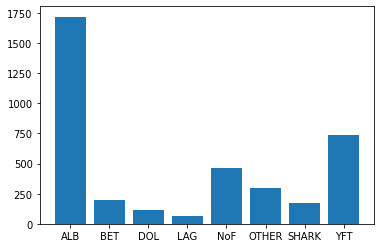

In [6]:
plt.bar(df.groupby('label').count().index,[elem[0] for elem in df.groupby('label').count().values])

Итак, виден сильный перекос в количестве данных: Альбакорский тунец представлен практически в 2 раза чаще, чем остальные группы вместе взятые. Запомним этот момент и в дальнейшем исправим.

### Разметка данных

Создадим словарь, куда внесем параметры разметки. Возьмем их из предварительно скачанных файлов .json (открываем их для чтения):

In [7]:
TRAIN_PREFIX = '../HW03/train_fish'

def load_annotations():
    boxes = dict()
    for path in glob('../HW03/*.json'):
        label = os.path.basename(path).split('_', 1)[0]
        with open(path) as src:
            for annotation in json.load(src):
                basename = os.path.basename(annotation['filename'])
                annotation['filename'] = os.path.join(
                    TRAIN_PREFIX, label.upper(), basename)
                for rect in annotation['annotations']:
                    rect['x'] += rect['width'] / 2
                    rect['y'] += rect['height'] / 2
                if os.path.isfile(annotation['filename']):
                    boxes.setdefault(label, []).append(annotation)
    return boxes

def draw_boxes(annotation, rectangles=None, image_size=None):
    
    def _draw(img, rectangles, scale_x, scale_y, color=(0, 255, 0)):
        for rect in rectangles:
            pt1 = (int((rect['x'] - rect['width'] / 2) * scale_x),
                   int((rect['y'] - rect['height'] / 2) * scale_y))
            pt2 = (int((rect['x'] + rect['width'] / 2) * scale_x),
                   int((rect['y'] + rect['height'] / 2) * scale_y))
            img = cv2.rectangle(img.copy(), pt1, pt2, 
                                color=color, thickness=4)
        return img
    
    scale_x, scale_y = 1., 1.
    
    img = cv2.imread(annotation['filename'], cv2.IMREAD_COLOR)[...,::-1]
    if image_size is not None:
        scale_x = 1. * image_size[0] / img.shape[1]
        scale_y = 1. * image_size[1] / img.shape[0]
        img = cv2.resize(img, image_size)
        
    img = _draw(img, annotation.get('annotations', []), scale_x, scale_y)
    
    if rectangles is not None:
        img = _draw(img, rectangles, 1., 1., (255, 0, 0))

    return img

In [8]:
boxes = load_annotations()  # загружаем разметку детекций
boxes['dol'][5]

{'annotations': [{'class': 'rect',
   'height': 102.93000000000018,
   'width': 135.36000000000024,
   'x': 293.28000000000054,
   'y': 329.2350000000006}],
 'class': 'image',
 'filename': '../HW03/train_fish/DOL/img_07302.jpg'}

Теперь у нас есть параметры разметки: высота, ширина, х и у.  
Визуализируем получившийся результат:

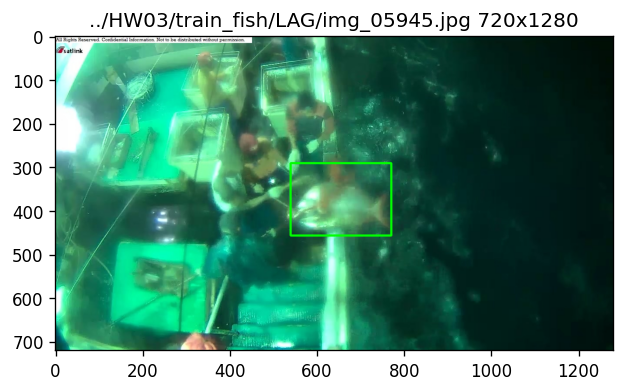

In [9]:
from matplotlib import pyplot as plt


annotation = boxes['lag'][18]
img = draw_boxes(annotation)

plt.figure(figsize=(6, 6), dpi=120)
plt.imshow(img)
plt.title('{} {}x{}'.format(
    annotation['filename'], img.shape[0], img.shape[1]));

Далее посмотрим на распределение размеров получившихся прямоугольников:

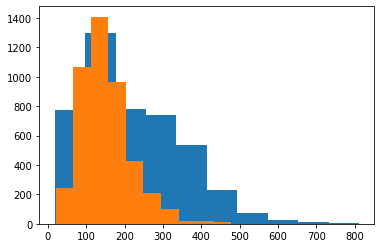

In [10]:
annotations = sum([box['annotations']
                   for box in sum(boxes.values(), [])], [])

widths = [rect['width'] for rect in annotations]
heights = [rect['height'] for rect in annotations]

plt.hist(widths)
plt.hist(heights);

Как можно заметить, большинство значений распределены в пределах 50-350. При этом стоит отметить, что часть разметок очень большие. (довольно длинный "хвост" в интервале значений >500).

### Работа с фотографиями

Переходим к фотографиям: будем формировать фичи и таргет.

In [11]:
def get_im_cv2(path):
    img = cv2.imread(path)
    resized = cv2.resize(img, (224, 224), cv2.INTER_LINEAR)
    return resized

def load_train():
    X_train = []
    X_train_id = []
    y_train = []
    start_time = time.time()

    print('Подготавливаем файлы тренировочного датасета')
    folders = ['ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT']
    for fld in folders:
        index = folders.index(fld)
        print('Загружена папка {} (индекс: {})'.format(fld, index))
        path = os.path.join('.', 'train_fish', fld, '*.jpg')
        files = glob(path)
        for fl in files:
            flbase = os.path.basename(fl)
            img = get_im_cv2(fl)
            X_train.append(img)
            X_train_id.append(flbase)
            y_train.append(index)

    print('Чтение тренировочных файлов: {} секунд'.format(round(time.time() - start_time, 2)))
    return X_train, y_train, X_train_id

In [12]:
def load_test1():
    path = os.path.join('.', 'test_stg1', '*.jpg')
    files = sorted(glob(path))

    X_test = []
    X_test_id = []
    for fl in files:
        flbase = os.path.basename(fl)
        img = get_im_cv2(fl)
        X_test.append(img)
        X_test_id.append(flbase)

    return X_test, X_test_id

In [13]:
def load_test2():    
    # заводим вторую функцию, т.к. принцип создания сабмитов по второму тестовому файлу несколько другой
    path = os.path.join('.', 'test_stg2', '*.jpg')
    files = sorted(glob(path))

    X_test = []
    X_test_id = []
    for fl in files:
        flbase = str(os.path.dirname(fl) + '/' + os.path.basename(fl))[2:]
        img = get_im_cv2(fl)
        X_test.append(img)
        X_test_id.append(flbase)

    return X_test, X_test_id         

Теперь функции для нормализации трейна и теста:

In [14]:
def normalize_train():
    train_data, train_target, train_id = load_train()

    print('Конвертация в массив numpy')
    train_data = np.array(train_data, dtype=np.uint8)
    train_target = np.array(train_target, dtype=np.uint8)

    print('Преобразование значений в вещественный тип')
    train_data = train_data.astype('float32')
    train_data = train_data / 255
    train_target = np_utils.to_categorical(train_target, 8)

    print('Размер тренировочного датасета:', train_data.shape)
    print(train_data.shape[0], 'train samples')
    return train_data, train_target, train_id

In [15]:
def normalize_test1():
    start_time = time.time()
    test_data, test_id = load_test1()

    test_data = np.array(test_data, dtype=np.uint8)

    test_data = test_data.astype('float32')
    test_data = test_data / 255

    print('Размер тестового датасета:', test_data.shape)
    print(test_data.shape[0], 'test samples')
    print('Чтение и предобработка тестовых файлов заняла: {} секунд'.format(round(time.time() - start_time, 2)))
    return test_data, test_id

In [16]:
def normalize_test2(X_test, X_test_id):
    start_time = time.time()
    
    test_data = np.array(X_test, dtype=np.uint8)

    test_data = test_data.astype('float32')
    test_data = test_data / 255

    print('Размер тестового датасета:', test_data.shape)
    print(test_data.shape[0], 'test samples')
    print('Чтение и предобработка тестовых файлов заняла: {} секунд'.format(round(time.time() - start_time, 2)))
    return test_data, X_test_id

И еще напишем функцию добавления результата в датафрейм (чтобы было удобно его сохранять):

In [17]:
def append_to_df(pred, id_img):
    df_all = pd.DataFrame(pred, columns=['ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT'])
    df_all.insert(0, 'image', pd.Series(id_img, index=df_all.index))

    df_all.index = df_all['image']
    df_all = df_all.drop('image', axis=1)
    return df_all

Поехали дальше. Запускаем функцию загрузки и нормализации  тренировочных данных:

In [18]:
X_train, y_train, X_train_id = normalize_train()

Подготавливаем файлы тренировочного датасета
Загружена папка ALB (индекс: 0)
Загружена папка BET (индекс: 1)
Загружена папка DOL (индекс: 2)
Загружена папка LAG (индекс: 3)
Загружена папка NoF (индекс: 4)
Загружена папка OTHER (индекс: 5)
Загружена папка SHARK (индекс: 6)
Загружена папка YFT (индекс: 7)
Чтение тренировочных файлов: 69.7 секунд
Конвертация в массив numpy
Преобразование значений в вещественный тип
Размер тренировочного датасета: (3777, 224, 224, 3)
3777 train samples


In [19]:
all_len, height, width, channels = np.array(X_train).shape
height, width, channels

(224, 224, 3)

Сделаем более удобный словарь разметки для итерации:

In [20]:
new_box = {}

for box in boxes:
    for lst in boxes[box]:
        if 'annotations' in lst.keys() and len(lst['annotations']) > 0:
            lst['filename'] = lst['filename'].rsplit('/', 2)[-1]
            new_box[lst['filename']] = lst['annotations'][-1]
            
# и отдельно пропишем, если на картинке нет рыбы:
no_fish_box = {'height': 0., 'width': 0., 'x': 0., 'y': 0.}            
for name in X_train_id:
    if not name in new_box.keys(): new_box[name] = no_fish_box
new_box

{'img_07898.jpg': {'class': 'rect',
  'height': 73.3200000000001,
  'width': 238.29000000000042,
  'x': 501.2550000000009,
  'y': 459.6600000000009},
 'img_07728.jpg': {'class': 'rect',
  'height': 204.4500000000004,
  'width': 283.4100000000006,
  'x': 568.9350000000011,
  'y': 526.6350000000009},
 'img_07693.jpg': {'class': 'rect',
  'height': 66.2700000000001,
  'width': 210.09000000000043,
  'x': 518.175000000001,
  'y': 451.9050000000008},
 'img_07643.jpg': {'class': 'rect',
  'height': 153.69000000000028,
  'width': 63.450000000000045,
  'x': 748.0050000000014,
  'y': 377.1750000000007},
 'img_07557.jpg': {'class': 'rect',
  'height': 69.09000000000015,
  'width': 219.96000000000038,
  'x': 356.73000000000064,
  'y': 481.5150000000009},
 'img_07302.jpg': {'class': 'rect',
  'height': 102.93000000000018,
  'width': 135.36000000000024,
  'x': 293.28000000000054,
  'y': 329.2350000000006},
 'img_07265.jpg': {'class': 'rect',
  'height': 67.68000000000018,
  'width': 540.030000000001

In [21]:
len(new_box)

3777

Уменьшим размерность данных разметки:

In [22]:
def convertation(img):
    box = []
    ANCHOR_WIDTH = 1280.   # возьмем максимально возможную ширину
    ANCHOR_HEIGHT = 720.   # возьмем максимально возможную высоту
    x_convert = (224. / ANCHOR_HEIGHT)
    y_convert = (224. / ANCHOR_WIDTH)
    box.append(new_box[img]['height'] * y_convert)
    box.append(new_box[img]['width'] * x_convert)
    box.append(max(new_box[img]['x'] * x_convert, 0))
    box.append(max(new_box[img]['y'] * y_convert, 0))
    return box

In [23]:
train_box = []
for i in range(len(X_train_id)):
    train_box.append(convertation(X_train_id[i]))

Проверим:

In [24]:
train_box[55]  # выведем конвертированные высоту, ширину, х и у разметки

[12.584250000000129, 27.636000000000262, 278.7726666666696, 43.30462500000044]

In [25]:
X_train_id[55]  # какой фотографии принадлежат параметры?

'img_02807.jpg'

In [26]:
# Перепроверим, действительно ли разметка сконвертирована:

for key, value in boxes.items():
    for i in range(len(value)):
        if X_train_id[55] == value[i]['filename']:
            print(value[i].values())

dict_values([[{'class': 'rect', 'height': 71.91000000000074, 'width': 88.83000000000084, 'x': 896.0550000000093, 'y': 247.45500000000254}], 'image', 'img_02807.jpg'])


### Создание модели

При создании модели обратим внимание, что на "input" подается картинка, а слои "output" - это разметка и таргет:

In [27]:
input_img = L.Input(shape=(224, 224, 3))   # фото


x = L.ZeroPadding2D((2, 2))(input_img)       # применим паддинг
x = L.Conv2D(512, 3, 3, activation='relu')(x)  # применим свёрточный слой и функцией активации relu
x = L.ZeroPadding2D((1, 1))(x)
x = L.Conv2D(512, 3, 3, activation='relu')(x)
x = L.MaxPooling2D(pool_size=(2, 2))(x)

x = L.ZeroPadding2D((1, 1))(input_img)       # применим паддинг
x = L.Conv2D(512, 3, 3, activation='relu')(x)  # применим свёрточный слой и функцией активации relu
x = L.ZeroPadding2D((1, 1))(x)
x = L.Conv2D(512, 3, 3, activation='relu')(x)
x = L.MaxPooling2D(pool_size=(2, 2))(x)

x = L.Flatten()(x)                           # вытягиваем в вектор
x = L.Dense(512, activation = 'relu')(x)
x = L.Dense(256, activation = 'relu')(x)

x_bb = L.Dense(4, name='box')(x)                               # box
x_class = L.Dense(8, activation='softmax', name='class')(x)    # таргет (8 классов)

model = Model([input_img], [x_bb, x_class])
model.compile(keras.optimizers.Adam(lr=0.001), loss=['mse', 'categorical_crossentropy'], metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 226, 226, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 75, 75, 512)  14336       zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
zero_padding2d_3 (ZeroPadding2D (None, 77, 77, 512)  0           conv2d_2[0][0]                   
______________________________________________________________________________________________

In [27]:
checkpoint_path = "../notebooks/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = keras.callbacks.ModelCheckpoint(filepath='../notebooks',
                                                 save_weights_only=True,
                                                 verbose=1)


model.fit(X_train, [np.asarray(train_box), y_train], batch_size=64, epochs=50, validation_split=0.1, callbacks=[cp_callback])

Epoch 1/50
54/54 [==============================] - 197s 4s/step - loss: 6611.5560 - box_loss: 6603.3063 - class_loss: 8.2493 - box_accuracy: 0.7740 - class_accuracy: 0.2849 - val_loss: 1768.2406 - val_box_loss: 1762.8945 - val_class_loss: 5.3459 - val_box_accuracy: 0.8122 - val_class_accuracy: 0.0000e+00

Epoch 00001: saving model to ../notebooks
Epoch 2/50
54/54 [==============================] - 202s 4s/step - loss: 2757.2106 - box_loss: 2754.5305 - class_loss: 2.6802 - box_accuracy: 0.7907 - class_accuracy: 0.3700 - val_loss: 1451.1528 - val_box_loss: 1444.4719 - val_class_loss: 6.6807 - val_box_accuracy: 0.8122 - val_class_accuracy: 0.0000e+00

Epoch 00002: saving model to ../notebooks
Epoch 3/50
54/54 [==============================] - 198s 4s/step - loss: 2515.7240 - box_loss: 2513.0416 - class_loss: 2.6823 - box_accuracy: 0.7798 - class_accuracy: 0.3418 - val_loss: 1643.4225 - val_box_loss: 1640.8624 - val_class_loss: 2.5601 - val_box_accuracy: 0.8122 - val_class_accuracy: 0.14


Epoch 00024: saving model to ../notebooks
Epoch 25/50
54/54 [==============================] - 192s 4s/step - loss: 219.6482 - box_loss: 218.9880 - class_loss: 0.6601 - box_accuracy: 0.8475 - class_accuracy: 0.7847 - val_loss: 599.8072 - val_box_loss: 598.6515 - val_class_loss: 1.1558 - val_box_accuracy: 0.8836 - val_class_accuracy: 0.5926

Epoch 00025: saving model to ../notebooks
Epoch 26/50
54/54 [==============================] - 193s 4s/step - loss: 208.2633 - box_loss: 207.5731 - class_loss: 0.6902 - box_accuracy: 0.8409 - class_accuracy: 0.7824 - val_loss: 640.2004 - val_box_loss: 638.9985 - val_class_loss: 1.2018 - val_box_accuracy: 0.8810 - val_class_accuracy: 0.5952

Epoch 00026: saving model to ../notebooks
Epoch 27/50
54/54 [==============================] - 193s 4s/step - loss: 171.6560 - box_loss: 171.1429 - class_loss: 0.5131 - box_accuracy: 0.8522 - class_accuracy: 0.8398 - val_loss: 654.3541 - val_box_loss: 653.4564 - val_class_loss: 0.8977 - val_box_accuracy: 0.8862 


Epoch 00048: saving model to ../notebooks
Epoch 49/50
54/54 [==============================] - 193s 4s/step - loss: 45.1115 - box_loss: 44.9056 - class_loss: 0.2059 - box_accuracy: 0.8726 - class_accuracy: 0.9401 - val_loss: 573.1183 - val_box_loss: 572.3329 - val_class_loss: 0.7855 - val_box_accuracy: 0.8889 - val_class_accuracy: 0.7487

Epoch 00049: saving model to ../notebooks
Epoch 50/50
54/54 [==============================] - 194s 4s/step - loss: 54.0476 - box_loss: 53.8490 - class_loss: 0.1986 - box_accuracy: 0.8827 - class_accuracy: 0.9397 - val_loss: 570.5710 - val_box_loss: 569.6329 - val_class_loss: 0.9381 - val_box_accuracy: 0.8757 - val_class_accuracy: 0.7143

Epoch 00050: saving model to ../notebooks


In [28]:
model.save('my_model.h5')

In [28]:
del X_train, train_box, y_train, model   # удаляем переменные, чтобы не засорять память

Вызовем модель:

In [18]:
new_model = keras.models.load_model('my_model.h5')

# Еще раз посмотрим на архитектуру модели
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 226, 226, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 75, 75, 512)  14336       zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
zero_padding2d_3 (ZeroPadding2D (None, 77, 77, 512)  0           conv2d_2[0][0]                   
______________________________________________________________________________________________

### Прогнозирование

Прежде всего проверим, как работает детекция для обнаружения рыб на тренировочном датасете. Напишем функцию, на вход принимающую фотографии в виде массива, id фотографий и аннотацию одного изображения, на котором будем предсказывать, в каком месте на картинке находится рыба: 

In [28]:
def check_pred_rectangle(df, df_id, annotation):
    image_id = annotation['filename'].split('/')[-1]   # находим id в аннотации
    index = [i for i in range(len(df_id)) if df_id[i] == image_id]  # фильтруем нужное id среди остальных
    
    pred = new_model.predict(df[index].reshape(1, 224, 224, 3), batch_size=64, verbose=2) # предсказываем
    
    # возвращаем параметры разметки в изначальный размер (для отрисовки картинки 720Х1280)
    h = (pred[0][0][0] / (224/1280))   
    w = (pred[0][0][1] / (224/720))
    x = (pred[0][0][2] / (224/720))
    y = (pred[0][0][3] / (224/1280))
    
    # создаем новую аннотацию (для предсказанных значений)
    pred_res = {}
    pred_res['annotations'] = []
    pred_dct = {}
    pred_dct['class'] = 'rect'  

    pred_dct['height'] =  h
    pred_dct['width'] =  w
    pred_dct['x'] =  x
    pred_dct['y'] =  y
    pred_res['class'] =  'image'
    pred_res['filename'] = annotation['filename']
    pred_res['annotations'].append(pred_dct)
    
    # отрисовываем реальную и предсказанную разметки
    img = draw_boxes(annotation)
    def _draw(img, rectangles, scale_x, scale_y, color=(0, 255, 0)):
        for rect in rectangles:
            pt1 = (int((rect['x'] - rect['width'] / 2) * scale_x),
                   int((rect['y'] - rect['height'] / 2) * scale_y))
            pt2 = (int((rect['x'] + rect['width'] / 2) * scale_x),
                   int((rect['y'] + rect['height'] / 2) * scale_y))
            img = cv2.rectangle(img.copy(), pt1, pt2, 
                                color=color, thickness=4)
        return img
    img1 = _draw(img, pred_res['annotations'], 1, 1, color=(0, 0, 255))

    plt.figure(figsize=(6, 6), dpi=120)
    plt.imshow(img)
    plt.imshow(img1)
    plt.title('{} {}x{}'.format(
        annotation['filename'], img.shape[0], img.shape[1]));
    plt.show()

1/1 - 0s


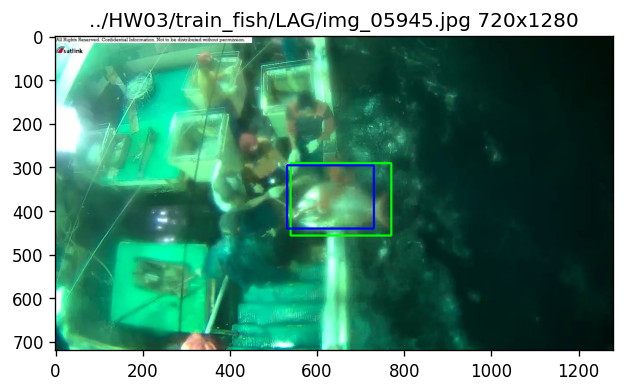

In [29]:
boxes = load_annotations()
check_pred_rectangle(X_train, X_train_id, boxes['lag'][18])

1/1 - 0s


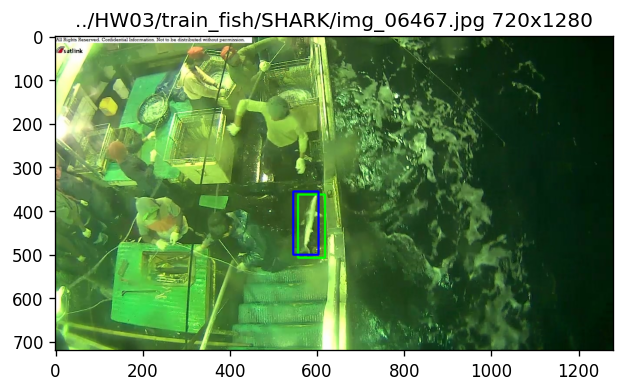

In [30]:
check_pred_rectangle(X_train, X_train_id, boxes['shark'][32])

1/1 - 0s


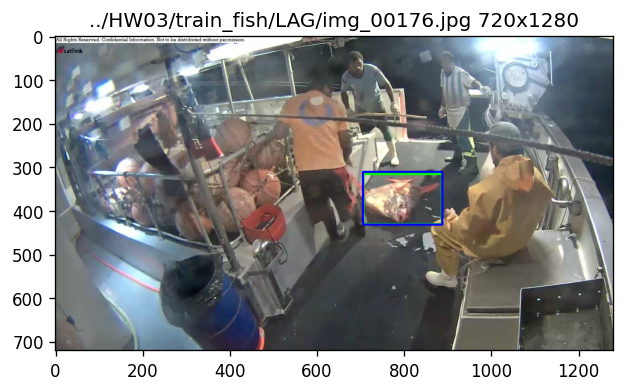

In [31]:
check_pred_rectangle(X_train, X_train_id, boxes['lag'][65])

1/1 - 0s


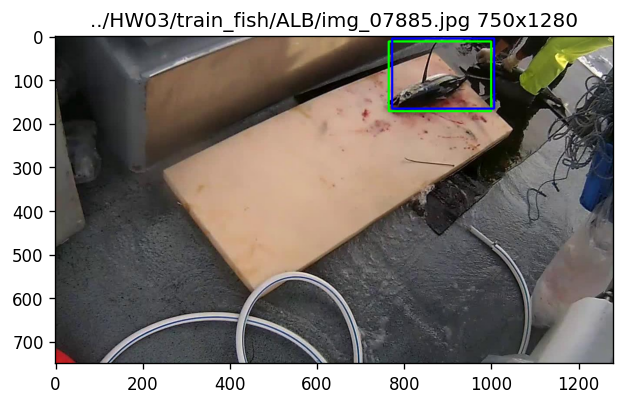

In [32]:
check_pred_rectangle(X_train, X_train_id, boxes['alb'][8])

1/1 - 0s


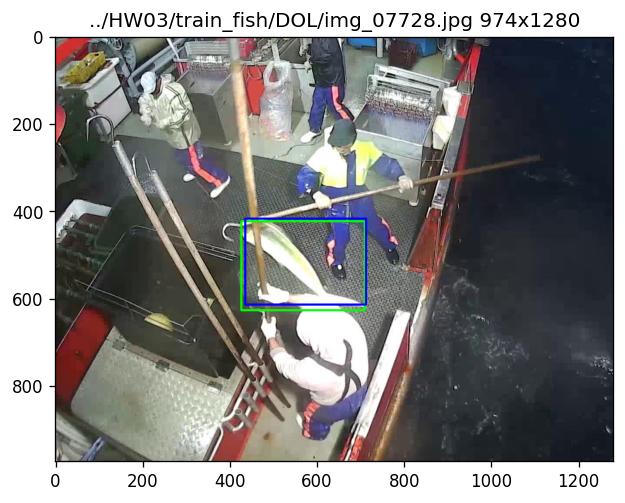

In [33]:
check_pred_rectangle(X_train, X_train_id, boxes['dol'][1])

Как видно, всё работает корректно.  
Переходим к предсказанию классов на тестовых файлах.

Загрузим первый тестовый файл:

In [36]:
X_test, X_test_id = normalize_test1()

Размер тестового датасета: (1000, 224, 224, 3)
1000 test samples
Чтение и предобработка тестовых файлов заняла: 18.42 секунд


**1. Предсказания для файла "test_stg1":**

In [37]:
test_predict1 = new_model.predict(X_test, batch_size=64, verbose=2)

16/16 - 20s


Создадим датафрейм, куда отправим полученные предсказания:

In [22]:
df_test1 = append_to_df(test_predict1[1], X_test_id)
df_test1

,ALB,BET,DOL,LAG,NoF,OTHER,SHARK,YFT
image,,,,,,,,
img_00005.jpg,0.000002,1.429304e-07,5.779845e-09,0.000000,9.999946e-01,6.661995e-13,5.385792e-14,0.000003
img_00007.jpg,0.865153,3.869509e-03,8.217010e-06,0.119869,3.314652e-13,3.318742e-03,1.486343e-08,0.007782
img_00009.jpg,0.856349,1.297001e-01,3.307887e-04,0.002119,8.890224e-10,8.421957e-03,1.605353e-05,0.003063
img_00018.jpg,0.939089,6.243972e-05,3.469216e-04,0.001198,9.149116e-11,5.928360e-02,5.398280e-08,0.000020
img_00027.jpg,0.686466,3.546805e-02,1.131836e-02,0.000002,7.495224e-07,1.361801e-01,5.185407e-05,0.130513
...,...,...,...,...,...,...,...,...
img_07905.jpg,0.815915,2.863855e-02,7.323341e-02,0.000004,2.335470e-07,3.220225e-02,4.780336e-06,0.050003
img_07906.jpg,0.124671,4.322049e-03,2.017874e-01,0.000095,1.081001e-08,8.072346e-02,1.038046e-07,0.588401
img_07908.jpg,0.978993,5.750918e-03,3.147975e-03,0.009353,8.632473e-11,2.457132e-03,3.456808e-06,0.000295


Теперь отправим получившийся результат в файл .csv:

In [34]:
df_test1.to_csv('submission01.csv')

In [35]:
del X_test, X_test_id, test_predict1

Переходим к второму тестовому файлу. Откроем его и преобразуем:

In [19]:
%%time
test_data2, test_id2 = load_test2()

CPU times: user 2min 29s, sys: 1.88 s, total: 2min 31s
Wall time: 2min 31s


In [20]:
len(test_data2)

12153

Поскольку объем данных слишком большой, нам придется делить его на несколько частей, чтобы модель смогла предсказать результат:

In [21]:
len(test_data2)

12153

In [22]:
12153/4

3038.25

Нормализуем:

In [23]:
%%time
test01 = normalize_test2(test_data2[:3038], test_id2[:3038])
test02 = normalize_test2(test_data2[3038:(3038*2)], test_id2[3038:(3038*2)])
test03 = normalize_test2(test_data2[(3038*2):(3038*3)], test_id2[(3038*2):(3038*3)])
test04 = normalize_test2(test_data2[(3038*3):], test_id2[(3038*3):])

Размер тестового датасета: (3038, 224, 224, 3)
3038 test samples
Чтение и предобработка тестовых файлов заняла: 2.25 секунд
Размер тестового датасета: (3038, 224, 224, 3)
3038 test samples
Чтение и предобработка тестовых файлов заняла: 3.96 секунд
Размер тестового датасета: (3038, 224, 224, 3)
3038 test samples
Чтение и предобработка тестовых файлов заняла: 6.54 секунд
Размер тестового датасета: (3039, 224, 224, 3)
3039 test samples
Чтение и предобработка тестовых файлов заняла: 17.02 секунд
CPU times: user 3.52 s, sys: 17 s, total: 20.5 s
Wall time: 29.8 s


**2. Предсказания для файла "test_stg2":**

Предсказывать тоже будем в 2 этапа: для первой половины фото и для второй:

In [24]:
%%time
test_predict2_1 = new_model.predict(test01[0], batch_size=64, verbose=2)

48/48 - 59s
CPU times: user 16min 32s, sys: 3min 36s, total: 20min 9s
Wall time: 1min


In [25]:
%%time
test_predict2_2 = new_model.predict(test02[0], batch_size=64, verbose=2)

48/48 - 54s
CPU times: user 15min 42s, sys: 2min 25s, total: 18min 7s
Wall time: 56.1 s


In [26]:
test_pred_2_all = np.concatenate((test_predict2_1[1],test_predict2_2[1]), axis=0)

In [30]:
df_test2 = append_to_df(test_pred_2_all, test_id2[:(3038*2)])

In [31]:
df_test2

,ALB,BET,DOL,LAG,NoF,OTHER,SHARK,YFT
image,,,,,,,,
test_stg2/image_00001.jpg,0.788594,0.089773,6.486590e-05,9.038528e-09,1.380312e-03,3.016759e-02,1.518146e-03,0.088502
test_stg2/image_00002.jpg,0.770607,0.004885,2.797665e-03,1.189201e-11,7.589138e-06,7.403622e-04,9.820453e-03,0.211142
test_stg2/image_00003.jpg,0.971274,0.000331,1.504743e-03,2.384321e-13,8.268759e-04,3.905472e-04,1.085766e-02,0.014815
test_stg2/image_00004.jpg,0.951497,0.016897,7.321554e-09,8.242037e-10,6.701563e-07,1.871355e-04,2.600071e-05,0.031392
test_stg2/image_00005.jpg,0.927615,0.021790,2.163970e-02,4.164173e-14,7.991999e-08,6.236027e-03,3.257644e-09,0.022719
...,...,...,...,...,...,...,...,...
test_stg2/image_06072.jpg,0.864986,0.003020,2.918520e-03,2.993259e-10,2.735915e-04,2.233492e-03,7.410297e-02,0.052465
test_stg2/image_06073.jpg,0.756755,0.214147,3.230969e-07,2.994128e-26,1.644848e-04,2.449720e-02,3.622536e-03,0.000813
test_stg2/image_06074.jpg,0.895179,0.000456,3.782106e-02,5.591989e-13,2.247087e-04,2.330780e-03,5.764625e-02,0.006343


In [32]:
df_test2.to_csv('submission02.csv')

In [33]:
del test_pred_2_all, df_test2, test01, test02

In [34]:
%%time
test_predict2_3 = new_model.predict(test03[0], batch_size=64, verbose=2)

48/48 - 55s
CPU times: user 16min 1s, sys: 2min 49s, total: 18min 51s
Wall time: 56.8 s


In [ ]:
%%time
test_predict2_4 = new_model.predict(test04[0], batch_size=64, verbose=2)

In [36]:
test_pred_3_all = np.concatenate((test_predict2_3[1],test_predict2_4[1]), axis=0)

In [38]:
df_test3 = append_to_df(test_pred_3_all, test_id2[(3038*2):])

In [39]:
df_test3

,ALB,BET,DOL,LAG,NoF,OTHER,SHARK,YFT
image,,,,,,,,
test_stg2/image_06077.jpg,0.934881,0.035136,1.305327e-04,1.000624e-13,1.136701e-07,4.079997e-04,2.246432e-02,0.006980
test_stg2/image_06078.jpg,0.589718,0.090900,3.350687e-02,5.204152e-19,2.006556e-01,1.019021e-02,2.934039e-03,0.072096
test_stg2/image_06079.jpg,0.933725,0.000429,2.097670e-06,1.313307e-11,2.412318e-08,8.646958e-03,2.936177e-03,0.054261
test_stg2/image_06080.jpg,0.708489,0.222015,3.409547e-04,9.249592e-12,1.403205e-03,3.661118e-02,3.089079e-03,0.028052
test_stg2/image_06081.jpg,0.776496,0.028612,1.082297e-02,1.481018e-18,1.152349e-01,3.033884e-04,1.848876e-03,0.066681
...,...,...,...,...,...,...,...,...
test_stg2/image_12149.jpg,0.000165,0.000004,5.530738e-08,5.793015e-34,9.998266e-01,2.859321e-09,1.035899e-14,0.000005
test_stg2/image_12150.jpg,0.923377,0.001025,1.353667e-02,7.451140e-09,1.745996e-08,2.180320e-02,5.967129e-05,0.040198
test_stg2/image_12151.jpg,0.712834,0.262154,6.213203e-07,4.225544e-24,1.421202e-06,2.159254e-02,8.649974e-04,0.002552


In [40]:
df_test3.to_csv('submission03.csv')

In [42]:
del test_pred_3_all, df_test3, test03, test04

##### Финальный этап.

Теперь открываем все наши предсказания и объединяем в один файл:

In [43]:
subm01 = pd.read_csv('submission01.csv')
subm02 = pd.read_csv('submission02.csv')
subm03 = pd.read_csv('submission03.csv')

In [44]:
subm01

,image,ALB,BET,DOL,LAG,NoF,OTHER,SHARK,YFT
0,img_00005.jpg,0.000002,1.429304e-07,5.779845e-09,0.000000,9.999946e-01,6.661995e-13,5.385792e-14,0.000003
1,img_00007.jpg,0.865153,3.869509e-03,8.217010e-06,0.119869,3.314652e-13,3.318742e-03,1.486343e-08,0.007782
2,img_00009.jpg,0.856349,1.297001e-01,3.307887e-04,0.002119,8.890224e-10,8.421958e-03,1.605354e-05,0.003063
3,img_00018.jpg,0.939089,6.243972e-05,3.469216e-04,0.001198,9.149116e-11,5.928360e-02,5.398280e-08,0.000020
4,img_00027.jpg,0.686466,3.546805e-02,1.131836e-02,0.000002,7.495224e-07,1.361801e-01,5.185407e-05,0.130513
...,...,...,...,...,...,...,...,...,...
995,img_07905.jpg,0.815915,2.863855e-02,7.323341e-02,0.000004,2.335470e-07,3.220225e-02,4.780336e-06,0.050003
996,img_07906.jpg,0.124671,4.322049e-03,2.017874e-01,0.000095,1.081001e-08,8.072346e-02,1.038046e-07,0.588401
997,img_07908.jpg,0.978993,5.750918e-03,3.147975e-03,0.009353,8.632472e-11,2.457132e-03,3.456808e-06,0.000295
998,img_07910.jpg,0.996027,1.498576e-05,3.325042e-08,0.000035,6.054129e-08,3.912038e-05,2.402912e-05,0.003860


In [45]:
subm02

,image,ALB,BET,DOL,LAG,NoF,OTHER,SHARK,YFT
0,test_stg2/image_00001.jpg,0.788594,0.089773,6.486590e-05,9.038528e-09,1.380313e-03,3.016759e-02,1.518146e-03,0.088502
1,test_stg2/image_00002.jpg,0.770607,0.004885,2.797665e-03,1.189201e-11,7.589138e-06,7.403622e-04,9.820453e-03,0.211142
2,test_stg2/image_00003.jpg,0.971274,0.000331,1.504743e-03,2.384321e-13,8.268759e-04,3.905472e-04,1.085766e-02,0.014815
3,test_stg2/image_00004.jpg,0.951497,0.016897,7.321554e-09,8.242037e-10,6.701563e-07,1.871355e-04,2.600071e-05,0.031392
4,test_stg2/image_00005.jpg,0.927615,0.021790,2.163970e-02,4.164172e-14,7.991999e-08,6.236027e-03,3.257644e-09,0.022719
...,...,...,...,...,...,...,...,...,...
6071,test_stg2/image_06072.jpg,0.864986,0.003020,2.918521e-03,2.993259e-10,2.735915e-04,2.233492e-03,7.410297e-02,0.052465
6072,test_stg2/image_06073.jpg,0.756755,0.214147,3.230969e-07,2.994128e-26,1.644848e-04,2.449720e-02,3.622536e-03,0.000813
6073,test_stg2/image_06074.jpg,0.895179,0.000456,3.782106e-02,5.591989e-13,2.247087e-04,2.330780e-03,5.764625e-02,0.006343
6074,test_stg2/image_06075.jpg,0.986844,0.000006,9.609857e-05,3.567604e-29,1.132282e-02,2.139400e-09,1.287411e-04,0.001602


In [46]:
subm03

,image,ALB,BET,DOL,LAG,NoF,OTHER,SHARK,YFT
0,test_stg2/image_06077.jpg,0.934881,0.035136,1.305327e-04,1.000624e-13,1.136701e-07,4.079997e-04,2.246432e-02,0.006980
1,test_stg2/image_06078.jpg,0.589718,0.090900,3.350687e-02,5.204151e-19,2.006556e-01,1.019021e-02,2.934039e-03,0.072096
2,test_stg2/image_06079.jpg,0.933725,0.000429,2.097670e-06,1.313307e-11,2.412318e-08,8.646958e-03,2.936177e-03,0.054261
3,test_stg2/image_06080.jpg,0.708489,0.222015,3.409548e-04,9.249592e-12,1.403205e-03,3.661118e-02,3.089079e-03,0.028052
4,test_stg2/image_06081.jpg,0.776496,0.028612,1.082297e-02,1.481018e-18,1.152349e-01,3.033884e-04,1.848876e-03,0.066681
...,...,...,...,...,...,...,...,...,...
6072,test_stg2/image_12149.jpg,0.000165,0.000004,5.530738e-08,5.793015e-34,9.998266e-01,2.859321e-09,1.035899e-14,0.000005
6073,test_stg2/image_12150.jpg,0.923377,0.001025,1.353667e-02,7.451140e-09,1.745996e-08,2.180320e-02,5.967129e-05,0.040198
6074,test_stg2/image_12151.jpg,0.712834,0.262154,6.213203e-07,4.225544e-24,1.421202e-06,2.159254e-02,8.649974e-04,0.002552
6075,test_stg2/image_12152.jpg,0.797769,0.076964,3.040135e-04,9.572637e-13,1.057138e-02,2.732616e-03,2.496214e-02,0.086697


In [49]:
subm_all = pd.concat([subm01, subm02, subm03], axis=0)
subm_all = subm_all.reset_index(drop=True)
subm_all

,image,ALB,BET,DOL,LAG,NoF,OTHER,SHARK,YFT
0,img_00005.jpg,0.000002,1.429304e-07,5.779845e-09,0.000000e+00,9.999946e-01,6.661995e-13,5.385792e-14,0.000003
1,img_00007.jpg,0.865153,3.869509e-03,8.217010e-06,1.198687e-01,3.314652e-13,3.318742e-03,1.486343e-08,0.007782
2,img_00009.jpg,0.856349,1.297001e-01,3.307887e-04,2.118673e-03,8.890224e-10,8.421958e-03,1.605354e-05,0.003063
3,img_00018.jpg,0.939089,6.243972e-05,3.469216e-04,1.197910e-03,9.149116e-11,5.928360e-02,5.398280e-08,0.000020
4,img_00027.jpg,0.686466,3.546805e-02,1.131836e-02,1.823050e-06,7.495224e-07,1.361801e-01,5.185407e-05,0.130513
...,...,...,...,...,...,...,...,...,...
13148,test_stg2/image_12149.jpg,0.000165,3.521806e-06,5.530738e-08,5.793015e-34,9.998266e-01,2.859321e-09,1.035899e-14,0.000005
13149,test_stg2/image_12150.jpg,0.923377,1.024864e-03,1.353667e-02,7.451140e-09,1.745996e-08,2.180320e-02,5.967129e-05,0.040198
13150,test_stg2/image_12151.jpg,0.712834,2.621540e-01,6.213203e-07,4.225544e-24,1.421202e-06,2.159254e-02,8.649974e-04,0.002552
13151,test_stg2/image_12152.jpg,0.797769,7.696445e-02,3.040135e-04,9.572637e-13,1.057138e-02,2.732616e-03,2.496214e-02,0.086697


И записываем получившееся решение в файл:

In [50]:
subm_all.to_csv('submission_all.csv')

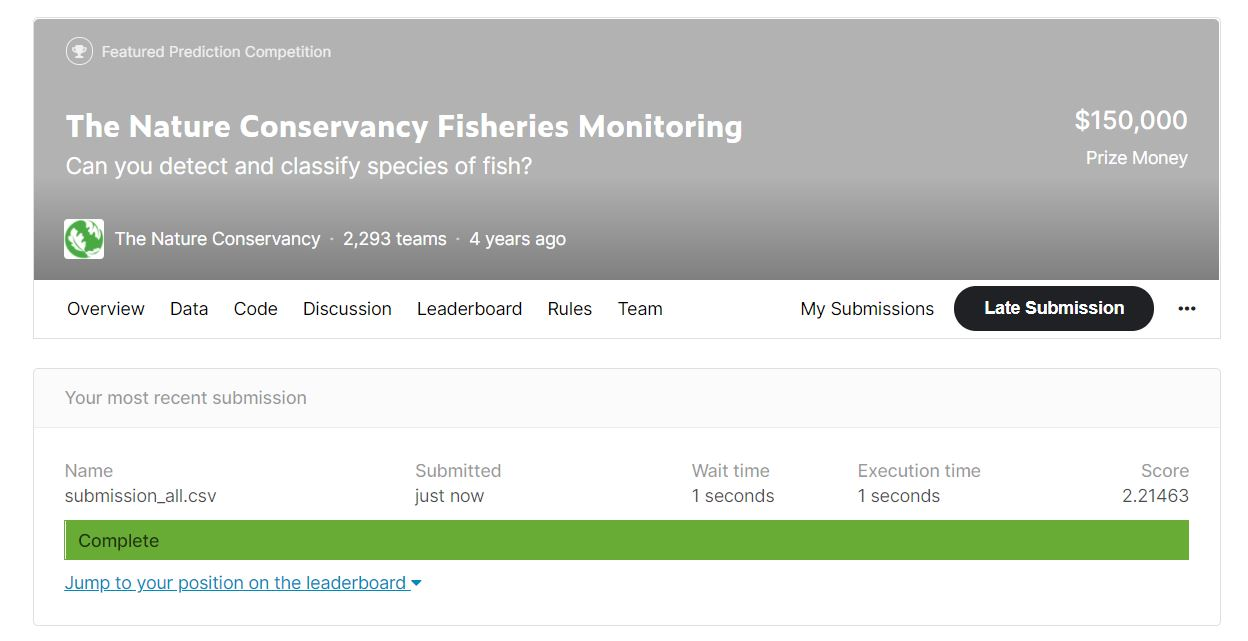

In [51]:
from IPython.display import Image
Image(filename='Subm.JPG')

Небольшой вывод: задание было очень сложным, но ииинтересным. Спасибо за возможность посоревноваться и получить новые знания!